In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 시드 설정
torch.manual_seed(1)

In [3]:
# 데이터 로딩
bostonDF = pd.read_csv('../data/boston.csv')
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형모델 => nn.Linear

In [4]:
# in_features : CRIM, ZN, ..., LSTAT
# out_features : MEDV
model = nn.Linear(len(bostonDF.columns[:-1]), 1) # 가중치, 절편 생성

In [5]:
# 가중치, 절편 확인
for i in model.named_parameters():
    print(i)

('weight', Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013]], requires_grad=True))
('bias', Parameter containing:
tensor([-0.1081], requires_grad=True))


In [6]:
# 모델의 가중치와 절편 최적화 (인스턴스에 전달)
adam_optim = optim.Adam(model.parameters(), lr = 0.1)
# 가중치, 절편을 전달하고 학습률을 설정

In [7]:
# 피쳐, 타겟 분리
featureTS = torch.from_numpy(bostonDF.iloc[:,:-1].values).float()
targetTS = torch.from_numpy(bostonDF[['MEDV']].values).float()

print(f"featureTS : {featureTS.shape}")
print(f"targetTS : {targetTS.shape}")

featureTS : torch.Size([506, 13])
targetTS : torch.Size([506, 1])


In [8]:
# 훈련, 검증, 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS,
                                                    train_size = 0.8, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    train_size = 0.8, random_state = 42)
print(f"train : {X_train.shape}, {y_train.shape}")
print(f"val : {X_val.shape}, {y_val.shape}")
print(f"test : {X_test.shape}, {y_test.shape}")

train : torch.Size([323, 13]), torch.Size([323, 1])
val : torch.Size([81, 13]), torch.Size([81, 1])
test : torch.Size([102, 13]), torch.Size([102, 1])


In [9]:
def testing(X_test, y_test, kind = 'val'):
    
    with torch.no_grad(): # 가중치, 절편 업데이트 X
        # (1) 순전파 (학습)
        pred_test_y = model(X_test)

        # (2) 손실 함수 계산
        loss_test = F.mse_loss(y_test, pred_test_y).item()
    
    return loss_test

In [10]:
def training(X_train, y_train, X_test, y_test, epoch = 10):
    EPOCH = epoch
    loss_train_history = []
    loss_test_history = []
    for i in range(1, EPOCH+1):
        # (1) 순전파 (학습)
        pred_train_y = model(X_train)

        # (2) 손실 함수 계산
        loss_train = F.mse_loss(y_train, pred_train_y)
        loss_test = testing(X_test, y_test)
        loss_train_history.append(loss_train.item())
        loss_test_history.append(loss_test)

        # (3) 최적화
        adam_optim.zero_grad() # 그레디언트 초기화
        loss_train.backward() # 역전파 하면서 그레디언트 계산
        adam_optim.step() # 가중치, 절편 업데이트

        # (4) 학습 결과 출력
        print(f"[Train : {i}/{EPOCH}] : {loss_train}")
        print(f"[Test  : {i}/{EPOCH}] : {loss_test}")
    
    return loss_train_history, loss_test_history

In [11]:
result = training(X_train, y_train, X_test, y_test)

[Train : 1/10] : 1153.1907958984375
[Test  : 1/10] : 1092.4178466796875
[Train : 2/10] : 3663.20947265625
[Test  : 2/10] : 4146.52734375
[Train : 3/10] : 934.6439819335938
[Test  : 3/10] : 1091.9281005859375
[Train : 4/10] : 358.1096496582031
[Test  : 4/10] : 306.208251953125
[Train : 5/10] : 1737.4613037109375
[Test  : 5/10] : 1703.950927734375
[Train : 6/10] : 1317.301513671875
[Test  : 6/10] : 1277.1781005859375
[Train : 7/10] : 243.49234008789062
[Test  : 7/10] : 198.3160858154297
[Train : 8/10] : 263.3260803222656
[Test  : 8/10] : 293.8450012207031
[Train : 9/10] : 946.3113403320312
[Test  : 9/10] : 1067.013671875
[Train : 10/10] : 960.100830078125
[Test  : 10/10] : 1078.385009765625


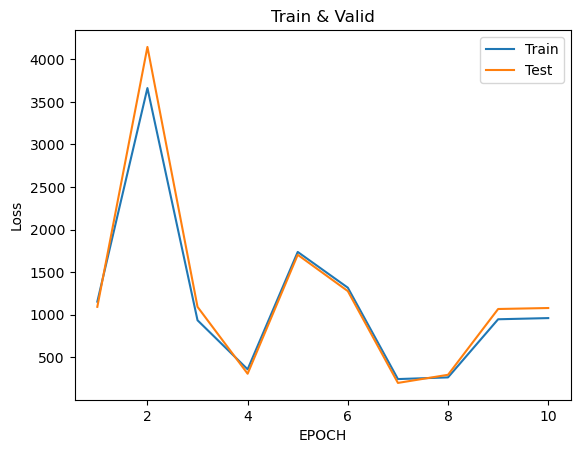

In [12]:
plt.plot(range(1, 11), result[0], label = 'Train')
plt.plot(range(1, 11), result[1], label = 'Test')
plt.title('Train & Valid')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()